In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, Attention, LayerNormalization, Dense
from sklearn import tree
from tensorflow.keras import models, layers
import warnings

from keras.metrics import Recall
from keras.metrics import Accuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('clean_sql_dataset.csv')

In [3]:
df.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148325 entries, 0 to 148324
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   148325 non-null  object
 1   Label   148325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
df.dropna(inplace=True)

In [6]:
X=df['Query']
y=df['Label']

In [7]:
max_words = len(list(X.str.split(' ', expand=True).stack().unique()))
max_words

611635

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
max_words = 611635
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
from keras.models import Sequential
model = Sequential(name="CNN")
model.add(Embedding(max_words,100,input_length=max_len))
model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))

In [11]:
model.add(layers.Dense(1, activation = 'relu'))
model.summary()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          61163500  
                                                                 
 conv1d (Conv1D)             (None, 147, 32)           12832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 73, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 128)           32896   

In [12]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history = model.fit(sequences_matrix,y_train, batch_size=512, epochs=50,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/50


186/186 [==============================] - 103s 538ms/step - loss: 0.3475 - accuracy: 0.8366 - val_loss: 0.0578 - val_accuracy: 0.9865
Epoch 2/50
186/186 [==============================] - 92s 492ms/step - loss: 0.0441 - accuracy: 0.9908 - val_loss: 0.0529 - val_accuracy: 0.9885
Epoch 3/50
186/186 [==============================] - 73s 392ms/step - loss: 0.0311 - accuracy: 0.9934 - val_loss: 0.0532 - val_accuracy: 0.9886
Epoch 4/50
186/186 [==============================] - 72s 389ms/step - loss: 0.0212 - accuracy: 0.9958 - val_loss: 0.0737 - val_accuracy: 0.9888
Epoch 5/50
186/186 [==============================] - 74s 397ms/step - loss: 0.0182 - accuracy: 0.9971 - val_loss: 0.0789 - val_accuracy: 0.9885


In [13]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [14]:
y_pred=model.predict(X_test_sequences_matrix)

928/928 [==============================] - 4s 4ms/step


In [15]:
print(y_pred)

[[ 8.350714]
 [10.833302]
 [ 0.      ]
 ...
 [ 0.      ]
 [ 0.      ]
 [ 2.364482]]


In [16]:
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    elif y_pred[i]<=0.5:
        y_pred[i]=0

In [17]:
print(y_pred)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
confusion_matrix(y_test, y_pred)  
plt.show()
accuracy= accuracy_score(y_test, y_pred)
precision= precision_score(y_test, y_pred, zero_division=1)
recall= recall_score(y_test, y_pred, zero_division=1)
f1_score= f1_score(y_test, y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, f1_score))

 Accuracy : 0.9869880330355638 
 Precision : 0.9981552246672816 
 Recall : 0.9769151405726076 
 F1 : 0.9874209737339503


In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[14129    28]
 [  358 15150]]


<Axes: >

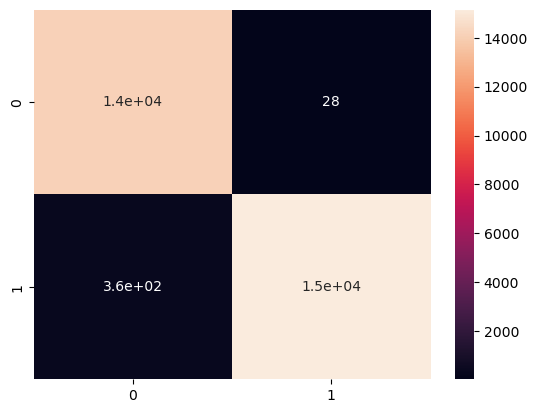

In [20]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [21]:
from keras.models import load_model
from pathlib import Path

model.save_weights("lstm_weights_bigdatasetCNNDenseLayersAdded.h5")
print('done')

model.save('lstm_weights_bigdatasetCNNDenseLayersAdded.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
loaded_model = tf.keras.models.load_model('lstm_weights_bigdatasetCNNDenseLayersAdded.h5')
loaded_model.load_weights('lstm_weights_bigdatasetCNNDenseLayersAdded.h5')

In [23]:
def clean_data(input_val):

    txts = tok.texts_to_sequences(input_val)
    input_val = sequence.pad_sequences(txts, maxlen=max_len)

    return input_val


def predict_sqli_attack():
    
    repeat=True
    
    space=''
    for i in range(20):
        space+= "-"

    print(space) 
    input_val=input("Please enter some data: ")
    print(space)

    
    if input_val== '0':
        repeat=False
    
    sample_texts_list = []
    sample_texts_list.append(input_val)
    txts = tok.texts_to_sequences(sample_texts_list)
    txts = sequence.pad_sequences(txts, maxlen=max_len)

    result=loaded_model.predict(txts)
    print(result)


    print(space)
    
    
    if repeat == True:
            if result > 0.5:
                 print("ALERT! This can be SQL injection")
            elif result <= 0.5:
                 print("It seems to be a benign")
            
            print(space)
        
            predict_sqli_attack()
            
    elif repeat == False:
        print( " Closing ")

In [24]:
predict_sqli_attack()

--------------------
Please enter some data: '
--------------------
1/1 [==============================] - 0s 180ms/step
[[0.03884553]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: ' '
--------------------
1/1 [==============================] - 0s 40ms/step
[[0.61065793]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------
Please enter some data: " "
--------------------
1/1 [==============================] - 0s 34ms/step
[[0.03884553]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: / /
--------------------
1/1 [==============================] - 0s 40ms/step
[[0.03884553]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: //
--------------------
1/1 [==============================] - 0s 33ms/step
[[0.03884553]]
--------------------
It seems to be a benign